In [1]:
import numpy as np
import pandas as pd
from collections import OrderedDict
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
df = pd.read_csv('CAM-01-SRV-lvm1.csv', header=None)
df.columns = ['Timestamp', 'Hostname', 'DiskNumber', 'Type', 'Offset', 'Size', 'ResponseTime']
df['Timestamp'] = df['Timestamp'].astype(np.int64)
df = df.sort_values(by='Timestamp')

In [3]:
def make_requests():
    for row in df.itertuples():
        yield getattr(row, 'Offset'), getattr(row, 'Size')

In [4]:
class Server:  # 服务器(cache)
    def __init__(self, space):
        self.space = space  # cache大小
        self.remain = space  # cache剩余空间
        self.cache = OrderedDict()  # OrderDict() 模拟cache LRU方法
        self.hit_count = 0  # 命中次数
        self.hit_byte = 0
        self.miss_count = 0  # 未命中次数
        self.miss_byte = 0

    def _hit(self, fid, size):
        self.hit_count += 1
        self.hit_byte += size
        self.cache.move_to_end(fid)

    def _miss(self, fid, size):
        self.miss_count += 1
        self.miss_byte += size
        while self.remain < size:
            self.remain += self.cache.popitem(last=False)[-1]  # pop出第一个item
        self.cache[fid] = size
        self.remain -= size

    def handle(self, fid, size):  # 处理一次请求
        if fid in self.cache.keys():
            self._hit(fid, size)
        else:
            self._miss(fid, size)

    def hit_rate(self):
        try:
            return self.hit_count / (self.hit_count + self.miss_count)
        except:
            return "Server has not been requested yet!"

    def byte_hit_rate(self):
        try:
            return self.hit_byte / (self.hit_byte + self.miss_byte)
        except:
            return "Server has not been requested yet!"

In [5]:
class Dispatcher1:
    def __init__(self, cache_size, cache_number, window_size=10000, simple=True):
        self.cache_number = cache_number
        self.big_cache = Server(cache_size * cache_number)
        self.small_caches = []
        for i in range(cache_number):
            server = Server(cache_size)
            self.small_caches.append(server)
        self.small_caches_heat = [0] * cache_number
        if simple:
            self.handle_requests = self.simple_hash
        else:
            self.handle_requests = self.load_balance
            self.file_mapper = {}
            for row in df.drop_duplicates(['Offset']).itertuples():
                fid = getattr(row, 'Offset')
                self.file_mapper[fid] = (fid // 10000 % 1000000) & 0b11111 % cache_number
        self.window = 0
        self.window_size = window_size

    def load_balance(self, fid, size):
        self.window += 1
        self.window %= self.window_size
        if self.window == 0:
            for i in range(self.cache_number):
                self.small_caches_heat[i] *= 0.7              # 保留上一个时间窗口的70%热度  可以修改
        server = self.file_mapper[fid]
        if fid in self.small_caches[server].cache.keys():
            self.small_caches[server].handle(fid, size)
            self.small_caches_heat[server] += size
        else:
            server = self.small_caches_heat.index(min(self.small_caches_heat))
            self.small_caches[server].handle(fid, size)
            self.file_mapper[fid] = server

        self.big_cache.handle(fid, size)

    def simple_hash(self, fid,  size):
        self.small_caches[(fid // 10000 % 1000000) & 0b11111 % self.cache_number].handle(fid, size)

In [6]:
class Dispatcher2:
    def __init__(self, cache_size, cache_number, window_size=10000, simple=True):
        self.cache_number = cache_number
        self.big_cache = Server(cache_size * cache_number)
        self.small_caches = []
        for i in range(cache_number):
            server = Server(cache_size)
            self.small_caches.append(server)
        self.small_caches_heat = [0] * cache_number
        if simple:
            self.handle_requests = self.simple_hash
        else:
            self.handle_requests = self.load_balance
            self.file_mapper = {}
            for row in df.drop_duplicates(['Offset']).itertuples():
                fid = getattr(row, 'Offset')
                self.file_mapper[fid] = (fid // 10000 % 1000000) & 0b11111 % cache_number
        self.window = 0
        self.window_size = window_size

    def load_balance(self, fid, size):
        self.window += 1
        self.window %= self.window_size
        if self.window == 0:
            for i in range(self.cache_number):
                self.small_caches_heat[i] *= 0.7               # 保留上一个时间窗口的70%热度  可以修改
        server = self.file_mapper[fid]
        if fid in self.small_caches[server].cache.keys():
            self.small_caches[server].handle(fid, size)
        else:
            server = self.small_caches_heat.index(min(self.small_caches_heat))
            self.small_caches[server].handle(fid, size)
            self.file_mapper[fid] = server
        self.small_caches_heat[server] += size
        self.big_cache.handle(fid, size)

    def simple_hash(self, fid,  size):
        self.small_caches[(fid // 10000 % 1000000) & 0b11111 % self.cache_number].handle(fid, size)

In [7]:
dispatcher1_small_server_hit_byte_ratio = []
dispatcher2_small_server_hit_byte_ratio = []
big_server_hit_byte_ratio = []

heat1_1 = []
heat1_2 = []
heat1_3 = []
heat1_4 = []
heat2_1 = []
heat2_2 = []
heat2_3 = []
heat2_4 = []

hit_ratio1 = []
hit_ratio2 = []
hit_ratio_big = []

small_hit_ratio1_1 = []
small_hit_ratio1_2 = []
small_hit_ratio1_3 = []
small_hit_ratio1_4 = []

small_hit_ratio2_1 = []
small_hit_ratio2_2 = []
small_hit_ratio2_3 = []
small_hit_ratio2_4 = []

time_array = []


small_cache_count_hit_ratio = []
small_cache_byte_hit_ratio = []

In [8]:
cache_size = 16384000000
CACHE_NUMBER = 4
dispatcher1 = Dispatcher1(cache_size, CACHE_NUMBER, 10000, False)
dispatcher2 = Dispatcher2(cache_size, CACHE_NUMBER, 10000, False)
time = 0
for fid, size in tqdm(make_requests()):
    dispatcher1.handle_requests(fid, size)
    dispatcher2.handle_requests(fid, size)
    time += 1
    if time % 100 == 0:
        time_array.append(time)
        
        heat1_1.append(dispatcher1.small_caches_heat[0])
        heat1_2.append(dispatcher1.small_caches_heat[1])
        heat1_3.append(dispatcher1.small_caches_heat[2])
        heat1_4.append(dispatcher1.small_caches_heat[3])
        
        heat2_1.append(dispatcher2.small_caches_heat[0])
        heat2_2.append(dispatcher2.small_caches_heat[1])
        heat2_3.append(dispatcher2.small_caches_heat[2])
        heat2_4.append(dispatcher2.small_caches_heat[3])
        
        
        hit_ratio = dispatcher1.small_caches[0].byte_hit_rate()
        small_hit_ratio1_1.append(hit_ratio)
        hit_ratio = dispatcher1.small_caches[1].byte_hit_rate()       
        small_hit_ratio1_2.append(hit_ratio)
        hit_ratio = dispatcher1.small_caches[2].byte_hit_rate()
        small_hit_ratio1_3.append(hit_ratio)
        hit_ratio = dispatcher1.small_caches[3].byte_hit_rate()
        small_hit_ratio1_4.append(hit_ratio)
        
        hit_ratio = dispatcher2.small_caches[0].byte_hit_rate()
        small_hit_ratio2_1.append(hit_ratio)
        hit_ratio = dispatcher2.small_caches[1].byte_hit_rate()       
        small_hit_ratio2_2.append(hit_ratio)
        hit_ratio = dispatcher2.small_caches[2].byte_hit_rate()
        small_hit_ratio2_3.append(hit_ratio)
        hit_ratio = dispatcher2.small_caches[3].byte_hit_rate()
        small_hit_ratio2_4.append(hit_ratio)
        
        
        hit_ratio1.append(sum([i.hit_byte for i in dispatcher1.small_caches]) / (dispatcher1.big_cache.hit_byte + dispatcher1.big_cache.miss_byte))
        hit_ratio2.append(sum([i.hit_byte for i in dispatcher2.small_caches]) / (dispatcher2.big_cache.hit_byte + dispatcher2.big_cache.miss_byte))
        hit_ratio_big.append(dispatcher1.big_cache.hit_byte / (dispatcher1.big_cache.hit_byte + dispatcher1.big_cache.miss_byte))

45283980it [08:12, 92002.92it/s] 


d:\program files\python 3.7.3\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


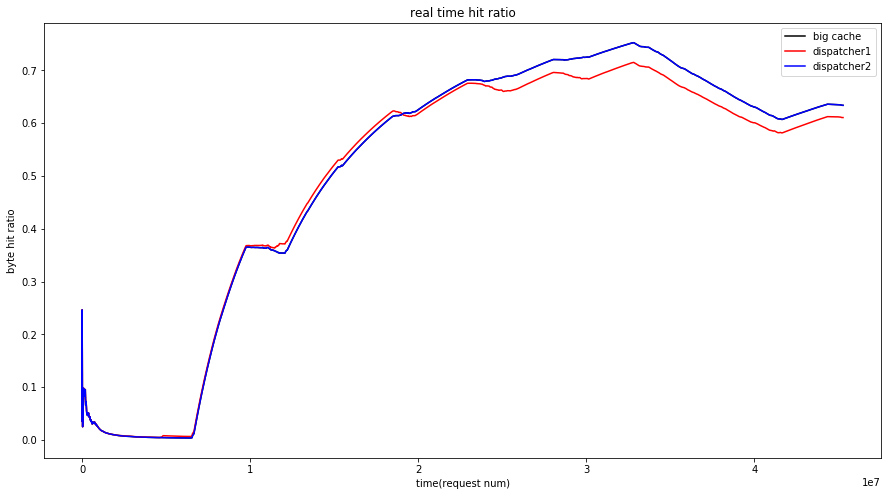

In [9]:
# 查看实时命中率
plt.figure(figsize=(15,8))
plt.plot(time_array, hit_ratio_big, color='black', label='big cache')
plt.plot(time_array, hit_ratio1, color='red', label='dispatcher1')
plt.plot(time_array, hit_ratio2, color='blue', label='dispatcher2')
plt.xlabel("time(request num)")
plt.ylabel("byte hit ratio")
plt.title('real time hit ratio')
plt.legend()
plt.show()

In [10]:
colors = ['gold', 'green', 'pink', 'brown']

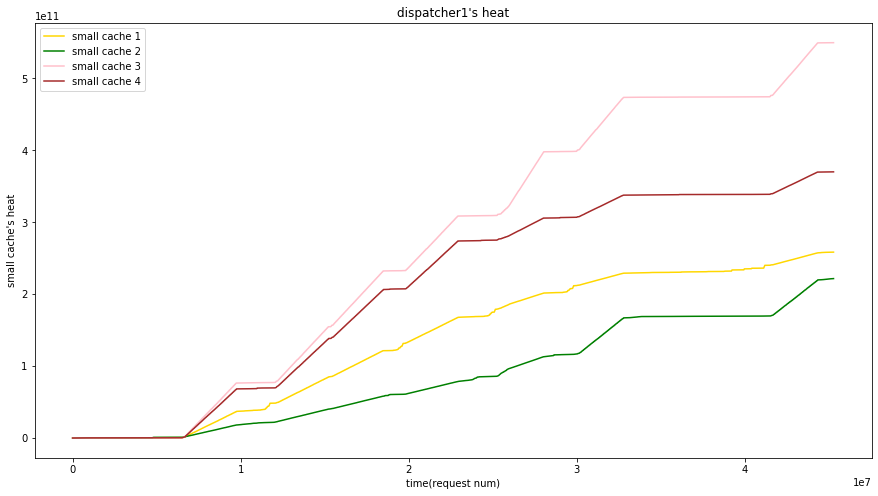

In [11]:
# dispatcher1中小cache热度实时变化情况
plt.figure(figsize=(15,8))

plt.plot(time_array, heat1_1, color=colors[0], label='small cache 1')
plt.plot(time_array, heat1_2, color=colors[1], label='small cache 2')
plt.plot(time_array, heat1_3, color=colors[2], label='small cache 3')
plt.plot(time_array, heat1_4, color=colors[3], label='small cache 4')

plt.xlabel("time(request num)")
plt.ylabel("small cache's heat")
plt.title("dispatcher1's heat")
plt.legend()
plt.show()

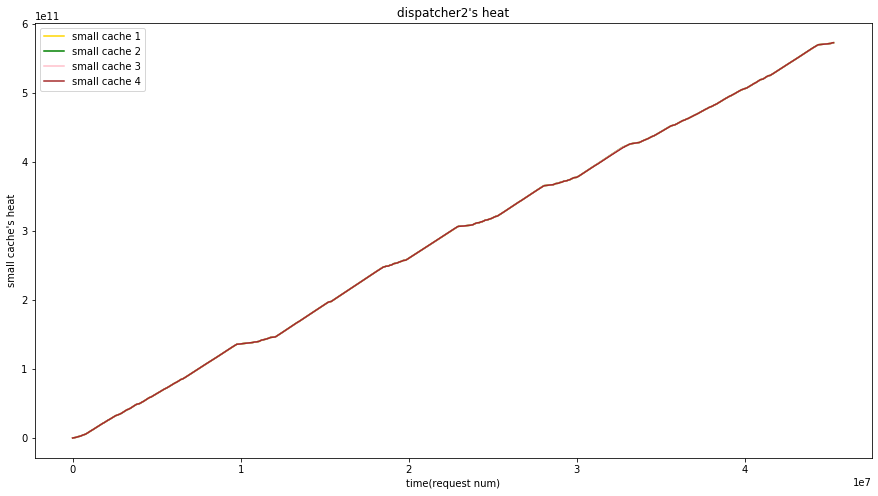

In [12]:
# dispatcher2中小cache热度实时变化情况
plt.figure(figsize=(15,8))

plt.plot(time_array, heat2_1, color=colors[0], label='small cache 1')
plt.plot(time_array, heat2_2, color=colors[1], label='small cache 2')
plt.plot(time_array, heat2_3, color=colors[2], label='small cache 3')
plt.plot(time_array, heat2_4, color=colors[3], label='small cache 4')

plt.xlabel("time(request num)")
plt.ylabel("small cache's heat")
plt.title("dispatcher2's heat")
plt.legend()
plt.show()

In [ ]:
# dispatcher1中小cache命中率实时变化情况
plt.figure(figsize=(15,8))

plt.plot(time_array, hit_ratio1, color='red', label='dispatcher1')
plt.plot(time_array, hit_ratio_big, color='black', label='big cache')
plt.plot(time_array, small_hit_ratio1_1, color=colors[0], label='small cache 1')
plt.plot(time_array, small_hit_ratio1_2, color=colors[1], label='small cache 2')
plt.plot(time_array, small_hit_ratio1_3, color=colors[2], label='small cache 3')
plt.plot(time_array, small_hit_ratio1_4, color=colors[3], label='small cache 4')

plt.xlabel("time(request num)")
plt.ylabel("small cache's hit ratio")
plt.title("dispatcher1")
plt.legend()
plt.show()

In [ ]:
# dispatcher2中小cache命中率实时变化情况
plt.figure(figsize=(15, 8))
plt.plot(time_array, hit_ratio1, color='red', label='dispatcher1')
plt.plot(time_array, hit_ratio_big, color='black', label='big cache')
plt.plot(time_array, small_hit_ratio2_1, color=colors[0], label='small cache 1')
plt.plot(time_array, small_hit_ratio2_2, color=colors[1], label='small cache 2')
plt.plot(time_array, small_hit_ratio2_3, color=colors[2], label='small cache 3')
plt.plot(time_array, small_hit_ratio2_4, color=colors[3], label='small cache 4')

plt.xlabel("time(request num)")
plt.ylabel("small cache's hit ratio")
plt.title("dispatcher2")
plt.legend()
plt.show()
